In [1]:
import math
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import boto3
import h5py
import numpy as np
import pandas as pd
from botocore import UNSIGNED
from botocore.client import Config
from tqdm.notebook import tqdm

In [2]:
skip_pull = False
version = "USA_2024_04_27_transformer_test_00"
root_folder = Path("data/resstock")
resstock_year = 2022
resstock_release = "tmy3_release_1.1"
amy_year = None
upgrade_state = 1

# set up depednencies
output_folder = root_folder / "features" / version / f"upgrade_{upgrade_state}"
output_folder.mkdir(parents=True, exist_ok=True)
resstock_data_path = output_folder / f"resstock.hdf"
resstock_output_path = output_folder / f"resstock_transformed.hdf"
print(f"Resstock data will be written to {resstock_data_path}")
print(f"Transformed data will be written to {resstock_output_path}")

Resstock data will be written to data\resstock\features\USA_2024_04_27_transformer_test_00\upgrade_1\resstock.hdf
Transformed data will be written to data\resstock\features\USA_2024_04_27_transformer_test_00\upgrade_1\resstock_transformed.hdf


In [3]:
states = [
    # "AK",
    "AL",
    "AR",
    "AZ",
    "CA",
    "CO",
    "CT",
    "DC",
    "DE",
    "FL",
    "GA",
    # "HI",
    "IA",
    "ID",
    "IL",
    "IN",
    "KS",
    "KY",
    "LA",
    "MA",
    "MD",
    "ME",
    "MI",
    "MN",
    "MO",
    "MS",
    "MT",
    "NC",
    "ND",
    "NE",
    "NH",
    "NJ",
    "NM",
    "NV",
    "NY",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VA",
    "VT",
    "WA",
    "WI",
    "WV",
    "WY",
]
assert (
    "AK" not in states and "HI" not in states
), "Hawaii and Alaska are not supported as upgrades are not always defined."

In [4]:
# nrel bucket config
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
b = "oedi-data-lake"
nrel_release_key = (
    Path("nrel-pds-building-stock")
    / "end-use-load-profiles-for-us-building-stock"
    / f"{resstock_year}"
    / f"resstock_{resstock_release}"
)
results_str_formatter = (
    lambda state, bid, upgrade_state: f"{nrel_release_key.as_posix()}/timeseries_individual_buildings/by_state/upgrade={upgrade_state}/state={state}/{bid}-{upgrade_state}.parquet"
)
epw_str_formatter = (
    lambda state, county, year: f"{nrel_release_key.as_posix()}/weather/state={state}/{county}_{year if  year else 'TMY3'}.csv"
)
assert (amy_year is not None and "amy" in resstock_release.lower()) or (
    amy_year is None and "tmy" in resstock_release.lower()
), "amy_year must be set if using amy data, and not set if using tmy data"


def get_state_df(state):
    try:
        upgrade_str = (
            "baseline" if upgrade_state == 0 else f"upgrade{upgrade_state:02d}"
        )
        k = f"{nrel_release_key.as_posix()}/metadata_and_annual_results/by_state/state={state}/csv/{state}_{upgrade_str}_metadata_and_annual_results.csv"

        r = s3.get_object(Bucket=b, Key=k)
        df = pd.read_csv(r["Body"])
        print("SUCCESS", k)
        return df
    except Exception as e:
        print("ERROR", k, e)
        return None


if skip_pull and Path(resstock_data_path).exists():
    resstock_df = pd.read_hdf(resstock_data_path, key="resstock")
else:
    resstock_dfs = {}

    with ThreadPoolExecutor(max_workers=10) as e:
        dfs = list(tqdm(e.map(get_state_df, states), total=len(states)))
        for state, df in zip(states, dfs):
            resstock_dfs[state] = df
    print(len(resstock_dfs))

    resstock_df = pd.concat(resstock_dfs.values())
    resstock_df.to_hdf(resstock_data_path, key="resstock", mode="w")

new_col_names = []
for x in resstock_df.columns:
    y = x.split(".")
    y = (y[0], ".".join(y[1:]))
    new_col_names.append(y)
resstock_df.columns = pd.MultiIndex.from_tuples(new_col_names)
resstock_df.reset_index(drop=True, inplace=True)
print(resstock_df.shape)

  0%|          | 0/49 [00:00<?, ?it/s]

SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=DC/csv/DC_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=AR/csv/AR_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=DE/csv/DE_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=IA/csv/IA_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=ID/csv/ID_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])
C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=AZ/csv/AZ_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=AL/csv/AL_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=CO/csv/CO_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=KS/csv/KS_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])
C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=KY/csv/KY_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=IN/csv/IN_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=CT/csv/CT_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=ME/csv/ME_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=LA/csv/LA_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=MD/csv/MD_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=MT/csv/MT_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=GA/csv/GA_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=MA/csv/MA_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=ND/csv/ND_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=MS/csv/MS_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])
C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=NE/csv/NE_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=NH/csv/NH_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=MO/csv/MO_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=MN/csv/MN_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=MI/csv/MI_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=NM/csv/NM_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=NV/csv/NV_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=OK/csv/OK_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])
C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=FL/csv/FL_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=NC/csv/NC_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=RI/csv/RI_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=OR/csv/OR_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=SD/csv/SD_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=NJ/csv/NJ_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=IL/csv/IL_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=SC/csv/SC_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=UT/csv/UT_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=VT/csv/VT_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])
C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=TN/csv/TN_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=WV/csv/WV_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=WY/csv/WY_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (61,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=CA/csv/CA_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=VA/csv/VA_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=WA/csv/WA_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])
C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=NY/csv/NY_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=PA/csv/PA_upgrade01_metadata_and_annual_results.csv
SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=WI/csv/WI_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=OH/csv/OH_upgrade01_metadata_and_annual_results.csv


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:29: DtypeWarning: Columns (121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r["Body"])


SUCCESS nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state=TX/csv/TX_upgrade01_metadata_and_annual_results.csv
49


C:\Users\szvsw\AppData\Local\Temp\ipykernel_36552\1352942123.py:49: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['in.ahs_region', 'in.ashrae_iecc_climate_zone_2004',
       'in.ashrae_iecc_climate_zone_2004_2_a_split',
       'in.bathroom_spot_vent_hour', 'in.building_america_climate_zone',
       'in.cec_climate_zone', 'in.ceiling_fan', 'in.census_division',
       'in.census_division_recs', 'in.census_region',
       ...
       'in.water_heater_efficiency', 'in.water_heater_fuel',
       'in.water_heater_in_unit', 'in.weather_file_city', 'in.window_areas',
       'in.windows', 'upgrade.ducts', 'upgrade.infiltration_reduction',
       'upgrade.insulation_ceiling', 'upgrade.insulation_wall'],
      dtype='object', length=145)]

  resstock_df.to_hdf(resstock_data_path, key="resstock", mode="w")


(548917, 346)


In [5]:
for col in resstock_df.upgrade.columns:
    if col == "":
        continue
    print("\n------", col, "-------")
    if col not in resstock_df["in"].columns:
        print(f"!NEWCOL {col}, {resstock_df.upgrade[col].unique()}")
    else:
        original = resstock_df["in"][col]

        new = resstock_df.upgrade[col]
        print(resstock_df.upgrade[col].isna().sum())
        print("new: ", set(new) - set(original))
        # print("all: ", set(original))


------ ducts -------
221493
new:  {nan}

------ infiltration_reduction -------
!NEWCOL infiltration_reduction, [nan '30%']

------ insulation_ceiling -------
193758
new:  {nan, 'R-60'}

------ insulation_wall -------
380143
new:  {nan, 'Wood Stud, R-13'}


## Definitions for lookups

In [6]:
EPD_BASELINE = 5.38  # Reference buildings apartment
LPD_BASELINE = 3.88  # Reference buildings apartment
ACH50_ACHNAT = 14.8  # LBL average for normal conditions
SQFT_M2 = 0.092903
F2F_HEIGHT = 3
RVAL_RSI = 1 / 5.678
PERIM_DEPTH = 3

VentilationPerArea = 0
VentilationPerPerson = 0
VentilationMode = 0
EconomizerSettings = 0
RecoverySettings = 0
RoofMass = 2

hvac_cooling_type = {"Central AC": 1, "None": 0, "Heat Pump": 3, "Room AC": 1}

heating_fuel = {
    "Electricity": 1,
    "Natural Gas": 0.85,
    "Propane": 0.8,
    "Other Fuel": 1,
    "Fuel Oil": 0.8,
    "None": 0,
}

lighting = {"100% CFL": 0.26, "100% LED": 0.22, "100% Incandescent": 1}


def get_people_density(x):
    (occupants, sqft) = x
    if type(occupants) == str and "+" in occupants:
        occupants = 10
    occupants = int(occupants)
    return occupants / (SQFT_M2 * sqft)


def get_infiltration(x):
    (ach50, sqft, floors) = x
    area = SQFT_M2 * sqft
    volume = area * F2F_HEIGHT
    surface_area = area + math.sqrt(area) * 4 * F2F_HEIGHT * int(floors)
    return (
        float(ach50.split(" ACH50")[0])
        / ACH50_ACHNAT
        * volume
        / 3.6
        / surface_area
        / 1000
    )


wall_thermal_mass_constructions = {
    "Brick": 0,
    "Wood Stud": 2,
    "CMU": 1,
}

roof_thermal_mass_constructions = {
    "Asphalt Shingles, Medium": 3,
    "Composition Shingles": 3,
    "Wood Shingles": 2,
    "Metal, Dark": 3,
    "Slate": 2,
    "Tile, Clay or Ceramic": 2,
    "Tile, Concrete": 0,
}


def get_wall_insulation(x):
    if "Uninsulated" in x:
        return 0.5
    else:
        return int(x.split("R-")[-1]) * RVAL_RSI


def get_slab_insulation(all_x):
    r_tot = [0]
    for x in all_x:
        if "None" in x:
            pass
        elif "Uninsulated" in x:
            r_tot.append(0.5)
        elif "R-" in x:
            x = x.split(",")
            x = [i for i in x if "R" in i]
            x = x[0]
            r_tot.append(int(x.split("R-")[-1]) * RVAL_RSI)
        else:
            x = x.split(" ")
            x = [i for i in x if "R" in i]
            x = x[0]
            r_tot.append(int(x.split("R")[-1]) * RVAL_RSI)
    return sum(r_tot) * RVAL_RSI


# From https://www.nrel.gov/docs/fy18osti/68670.pdf
windows_uval = {
    "Double, Clear, Metal, Air": 0.76 * 5.678,
    "Double, Clear, Metal, Air, Exterior Clear Storm": 0.38 * 5.678,
    "Double, Clear, Non-metal, Air": 0.49 * 5.678,
    "Double, Clear, Non-metal, Air, Exterior Clear Storm": 0.29 * 5.678,
    "Double, Low-E, Non-metal, Air, M-Gain": 0.29 * 5.678,  # assumed
    "Single, Clear, Metal": 1.16 * 5.678,
    "Single, Clear, Metal, Exterior Clear Storm": 0.69 * 5.678,
    "Single, Clear, Non-metal": 0.84 * 5.678,
    "Single, Clear, Non-metal, Exterior Clear Storm": 0.4 * 5.678,
    "Triple, Low-E, Non-metal, Air, L-Gain": 0.4 * 5.678,
}

windows_shgc = {
    "Double, Clear, Metal, Air": 0.67,
    "Double, Clear, Metal, Air, Exterior Clear Storm": 0.51,
    "Double, Clear, Non-metal, Air": 0.56,
    "Double, Clear, Non-metal, Air, Exterior Clear Storm": 0.42,
    "Double, Low-E, Non-metal, Air, M-Gain": 0.52,  # assumed
    "Single, Clear, Metal": 0.76,
    "Single, Clear, Metal, Exterior Clear Storm": 0.59,
    "Single, Clear, Non-metal": 0.63,
    "Single, Clear, Non-metal, Exterior Clear Storm": 0.51,
    "Triple, Low-E, Non-metal, Air, L-Gain": 0.51,
}


def get_perim2core(x):
    a = x / 10.7
    x = math.sqrt(a)
    core_area = (x - 2 * PERIM_DEPTH) ** 2
    perim_area = a - core_area
    return core_area / perim_area


def get_core_depth(x, perim_depth=PERIM_DEPTH):
    core_area_to_perim_area = get_perim2core(x)
    return core_area_to_perim_area * perim_depth


def get_orientation(x):
    if x not in ["North" "East" "South" "West"]:
        return math.pi / 4
    else:
        return 0


def get_roof2floor(x):
    r2f = 0
    if x[0] != "Middle" and x[1] != "Middle":
        r2f = 1
    elif x[2] != "None":
        r2f = 0.5
    return r2f


def get_ground2floor(x):
    if x == "Middle" or x == "Top":
        return 0
    if x == "Bottom":
        return 1
    # if x[1] == "Slab":
    #     return 1
    # if x[1] == "Heated Basement" or x[1] == "Ambient":
    #     return 0
    else:
        return 1


def get_shading_height(x):
    """
    Gets shading angle given x distance away, and assumed similar height of adjascent building
    """
    (dist, floors) = x
    if dist == "None":
        return 0
    elif "ft" in dist:
        dist = 15
    else:
        dist = int(dist)

    height = F2F_HEIGHT * floors
    return math.atan(height / dist)

## Space definition

In [41]:
print(
    resstock_df[
        resstock_df[("in", "geometry_attic_type")]
        == "Finished Attic or Cathedral Ceilings"
    ][("in", "geometry_building_horizontal_location_mf")].unique()
)
print(
    resstock_df[resstock_df[("in", "geometry_attic_type")] == "Vented Attic"][
        ("in", "geometry_building_horizontal_location_sfa")
    ].unique()
)

['None']
['None' 'Middle' 'Right' 'Left']


In [42]:
resstock_df[("in", "natural_ventilation")].unique()

array(['Cooling Season, 7 days/wk'], dtype=object)

In [43]:
resstock_df[("in", "geometry_building_level_mf")].unique()

array(['None', 'Bottom', 'Middle', 'Top'], dtype=object)

In [7]:
space_definition = {
    "area": {
        "name": "area",
        "resstock_path": ["sqft"],
        "resstock_format": lambda x: x / 10.7,
    },
    "climate_zone": {
        "name": "epw",
        "resstock_path": ["ashrae_iecc_climate_zone_2004"],
        "resstock_format": lambda x: x,  # TODO get epw for climate zone
    },
    "state": {
        "name": "state",
        "resstock_path": ["state"],
        "resstock_format": lambda x: x,  # TODO get epw for state if possible
    },
    "county": {
        "name": "county",
        "resstock_path": ["county"],
        "resstock_format": lambda x: x,  # TODO get epw for city if possible
    },
    "city": {
        "name": "epw",
        "resstock_path": ["city"],
        "resstock_format": lambda x: x,  # TODO get epw for city if possible
    },
    "floors": {
        "name": "floors",
        "resstock_path": ["geometry_stories"],
        "resstock_format": lambda x: x,
    },
    "width": {
        "name": "width",
        "min": 2,
        "max": 8,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 3,
    },
    "height": {
        "name": "height",
        "min": 2.5,
        "max": 6,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 3,
    },
    "perim_depth": {
        "name": "perim_depth",  # assume square
        "min": 1.25,
        "max": 12,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": PERIM_DEPTH,
    },
    "core_depth": {
        "name": "core_depth",
        "min": 1.25,
        "max": 60,
        "mode": "Continuous",
        "resstock_path": ["sqft"],
        "resstock_format": lambda x: get_core_depth(x),
    },
    "roof_2_footprint": {
        "name": "roof_2_footprint",
        "min": 0.0,
        "max": 1.0,
        "mode": "Continuous",
        "resstock_path": [
            "geometry_building_horizontal_location_sfa",
            "geometry_building_horizontal_location_mf",
            "geometry_attic_type",
            # "geometry_building_level_mf",
        ],
        # "resstock_format": lambda x: 1 if x[0] != "Middle" and x[1] != "Middle" else 0,
        "resstock_format": lambda x: get_roof2floor(x),
    },
    "ground_2_footprint": {
        "name": "ground_2_footprint",
        "min": 0.0,
        "max": 1.0,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 1,
        # "resstock_path": ["geometry_stories"],
        # "resstock_format": lambda x: get_ground2floor(x),
    },
    "orientation": {
        "name": "orientation",
        "min": 0.0,
        "max": 6.283185307179586,
        "mode": "Continuous",
        "resstock_path": ["orientation"],
        "resstock_format": lambda x: get_orientation(x),
    },
    "wwr": {
        "name": "wwr",
        "min": 0.0,
        "max": 0.9,
        "mode": "Continuous",
        "resstock_path": ["window_areas"],  # Format: "F18 B18 L18 R18"
        "resstock_format": lambda x: float(x.split(" ")[0].split("F")[1]) / 100,
    },
    "cop_cooling": {
        "name": "cop_cooling",
        "min": 2,
        "max": 6,
        "mode": "Continuous",
        "resstock_path": ["hvac_cooling_type"],
        "resstock_format": lambda x: hvac_cooling_type[x],
    },
    "cop_heating": {
        "name": "cop_heating",
        "min": 0.5,
        "max": 6,
        "mode": "Continuous",
        "resstock_path": [
            "heating_fuel"
        ],  # Format: ['Electricity', 'Natural Gas', 'Propane', 'Other Fuel', 'Fuel Oil','None']
        "resstock_format": lambda x: heating_fuel[x],
    },
    "HeatingSetpoint": {
        "name": "HeatingSetpoint",
        "min": 14,
        "max": 24,
        "mode": "Continuous",
        "resstock_path": ["heating_setpoint"],  # Format: F75
        "resstock_format": lambda x: (float(x.split("F")[0]) - 32) * 5 / 9,
    },
    "CoolingSetpoint": {
        "name": "CoolingSetpoint",
        "min": 22,
        "max": 30,
        "mode": "Continuous",
        "resstock_path": ["cooling_setpoint"],  # Format: 75F
        "resstock_format": lambda x: (float(x.split("F")[0]) - 32) * 5 / 9,
    },
    "LightingPowerDensity": {
        "name": "LightingPowerDensity",
        "min": 0,
        "max": 30,
        "mode": "Continuous",
        "resstock_path": [
            "lighting"
        ],  # Format: ['100% CFL', '100% LED', '100% Incandescent']
        "resstock_format": lambda x: lighting[x],
    },
    "EquipmentPowerDensity": {
        "name": "EquipmentPowerDensity",
        "min": 0,
        "max": 60,
        "mode": "Continuous",
        "resstock_path": [
            "plug_loads"
        ],  # Format: "XXX%" # NOTE plug_load_diversity is to add variation to schedules
        "resstock_format": lambda x: float(x.split("%")[0]) / 100 * EPD_BASELINE,
    },
    "PeopleDensity": {
        "name": "PeopleDensity",
        "min": 0,
        "max": 0.5,
        "mode": "Continuous",
        "resstock_path": ["occupants", "sqft"],  # Format: int, "int", "+10"
        "resstock_format": lambda x: get_people_density(x),
    },
    "Infiltration": {
        "name": "Infiltration",
        "min": 0.0,
        "max": 0.001,
        "mode": "Continuous",
        "resstock_path": [
            "infiltration",
            "sqft",
            "geometry_stories",
        ],  # Format: "X ACH50" + "natural_ventilation"?
        "resstock_format": lambda x: get_infiltration(x),
    },
    "VentilationPerArea": {
        "name": "VentilationPerArea",
        "min": 0.0,
        "max": 0.005,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "VentilationPerPerson": {
        "name": "VentilationPerPerson",
        "min": 0,
        "max": 0.015,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "VentilationMode": {
        "name": "VentilationMode",
        "option_count": 3,
        "mode": "Onehot",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "FacadeMass": {
        "name": "FacadeMass",
        "option_count": 4,
        "mode": "Onehot",
        "resstock_path": ["insulation_wall"],
        "resstock_format": lambda x: wall_thermal_mass_constructions[x.split(", ")[0]],
    },
    "RoofMass": {
        "name": "RoofMass",
        "option_count": 4,
        "mode": "Onehot",
        "resstock_path": ["roof_material"],
        "resstock_format": lambda x: roof_thermal_mass_constructions[x],
    },
    "FacadeRValue": {
        "name": "FacadeRValue",
        "min": 0.3,
        "max": 15,
        "mode": "Continuous",
        "resstock_path": ["insulation_wall"],
        "resstock_format": lambda x: get_wall_insulation(x),
    },
    "RoofRValue": {
        "name": "RoofRValue",
        "min": 0.3,
        "max": 18,
        "mode": "Continuous",
        "resstock_path": ["insulation_roof"],
        "resstock_format": lambda x: get_wall_insulation(x),
    },
    "SlabRValue": {
        "name": "SlabRValue",
        "min": 0.3,
        "max": 15,
        "mode": "Continuous",
        "resstock_path": [
            "insulation_slab",
            "insulation_rim_joist",
            "insulation_foundation_wall",
        ],  # Format:
        "resstock_format": lambda x: get_slab_insulation(x),
    },
    "WindowUValue": {
        "name": "WindowUValue",
        "min": 0.3,
        "max": 7.0,
        "mode": "Continuous",
        "resstock_path": ["windows"],
        "resstock_format": lambda x: windows_uval[x],
    },
    "WindowShgc": {
        "name": "WindowShgc",
        "min": 0.05,
        "max": 0.99,
        "mode": "Continuous",
        "resstock_path": ["windows"],
        "resstock_format": lambda x: windows_shgc[x],
    },
    "EconomizerSettings": {
        "name": "EconomizerSettings",
        "option_count": 2,
        "mode": "Onehot",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "ShadHeight": {
        "name": "EconomizerSettings",
        "option_count": 2,
        "mode": "Onehot",
        "resstock_path": ["neighbors", "geometry_stories"],
        "resstock_format": lambda x: get_shading_height(x),
    },
}

## Fetch data

### One building

In [45]:
resstock_df.reset_index().groupby(("upgrade", "infiltration_reduction")).first()

index bldg_id upgrade      weight  \
                                                                      
(upgrade, infiltration_reduction)                                     
30%                                   2     239       2  242.131013   

                                  applicability      in  \
                                                   sqft   
(upgrade, infiltration_reduction)                         
30%                                        True  1690.0   

                                                                \
                                                    ahs_region   
(upgrade, infiltration_reduction)                                
30%                                Non-CBSA East South Central   

                                                                 \
                                  ashrae_iecc_climate_zone_2004   
(upgrade, infiltration_reduction)                                 
30%                                                          3A   

                                                                           \
                                  ashrae_iecc_climate_zone_2004_2_a_split   
(upgrade, infiltration_reduction)                                           
30%                                                                    3A   

                                                           ...  \
                                  bathroom_spot_vent_hour  ...   
(upgrade, infiltration_reduction)                          ...   
30%                                                Hour20  ...   

                                                                                                    out  \
                                  emissions_reduction.all_fuels.lrmer_low_re_cost_15_2025_start.co2e_kg   
(upgrade, infiltration_reduction)                                                                         
30%                                                                      1642.907935                      

                                                                                                         \
                                  emissions_reduction.all_fuels.lrmer_low_re_cost_25_2025_start.co2e_kg   
(upgrade, infiltration_reduction)                                                                         
30%                                                                      1410.865501                      

                                                                                                      \
                                  emissions_reduction.all_fuels.lrmer_mid_case_15_2025_start.co2e_kg   
(upgrade, infiltration_reduction)                                                                      
30%                                                                      2153.747745                   

                                            upgrade                           \
                                              ducts geometry_foundation_type   
(upgrade, infiltration_reduction)                                              
30%                                10% Leakage, R-8      Unvented Crawlspace   

                                                      \
                                  insulation_ceiling   
(upgrade, infiltration_reduction)                      
30%                                             R-49   

                                                              \
                                  insulation_foundation_wall   
(upgrade, infiltration_reduction)                              
30%                                      Wall R-10, Interior   

                                                                        \
                                  insulation_rim_joist insulation_roof   
(upgrade, infiltration_reduction)                                        
30%                                     R-10, Exterior  Finished, R-30   

                             

In [46]:
sb_config = {}
i = 2
for k, data in space_definition.items():
    if data["resstock_path"]:
        if len(data["resstock_path"]) == 1:
            x = resstock_df.loc[i, ("in", data["resstock_path"][0])]
            y = data["resstock_format"](x)
            sb_config[k] = y

        else:
            x = []
            # collected = []
            for j in data["resstock_path"]:
                x.append(resstock_df.loc[i, ("in", j)])
            y = data["resstock_format"](x)

            if k == "Infiltration":
                if ("upgrade", "infiltration_reduction") in resstock_df.columns:
                    if isinstance(
                        resstock_df.loc[i, ("upgrade", "infiltration_reduction")], str
                    ):
                        assert resstock_df.loc[
                            i, ("upgrade", "infiltration_reduction")
                        ].startswith(
                            "30"
                        ), "Looks like a value other than 30 comes up in some other upgrade package!"
                        y = y * 0.7
            sb_config[k] = y

    else:
        sb_config[k] = data["resstock_format"]
sb_config

{'area': 157.94392523364488,
 'climate_zone': '3A',
 'state': 'AL',
 'county': 'G0100390',
 'city': 'Not in a census Place',
 'floors': 1,
 'width': 3,
 'height': 3,
 'perim_depth': 3,
 'core_depth': 1.127062914026045,
 'roof_2_footprint': 1,
 'ground_2_footprint': 1,
 'orientation': 0.7853981633974483,
 'wwr': 0.12,
 'cop_cooling': 1,
 'cop_heating': 1,
 'HeatingSetpoint': 22.22222222222222,
 'CoolingSetpoint': 23.88888888888889,
 'LightingPowerDensity': 0.26,
 'EquipmentPowerDensity': 5.918,
 'PeopleDensity': 0.019107541510974702,
 'Infiltration': 0.0004026633431675842,
 'VentilationPerArea': 0,
 'VentilationPerPerson': 0,
 'VentilationMode': 0,
 'FacadeMass': 0,
 'RoofMass': 3,
 'FacadeRValue': 1.2328284607256075,
 'RoofRValue': 0.5,
 'SlabRValue': 0.08805917576611483,
 'WindowUValue': 1.64662,
 'WindowShgc': 0.52,
 'EconomizerSettings': 0,
 'ShadHeight': 0.19739555984988078}

In [47]:
for col in resstock_df["in"].columns:
    if col in resstock_df.upgrade.columns:
        is_upgrading = resstock_df.upgrade[col].notna()
        resstock_df.loc[is_upgrading, ("in", col)] = resstock_df.loc[
            is_upgrading, ("upgrade", col)
        ]

### All buildings

In [49]:
sb_data = []
for i, row in tqdm(resstock_df.iterrows(), total=resstock_df.shape[0]):
    sb_config = {}
    sb_config["building_id"] = row["bldg_id"].iloc[0]
    for k, data in space_definition.items():
        if data["resstock_path"]:
            if len(data["resstock_path"]) == 1:
                x = row[("in", data["resstock_path"][0])]
                y = data["resstock_format"](x)
                sb_config[k] = y

            else:
                x = []
                # collected = []
                for j in data["resstock_path"]:
                    x.append(row[("in", j)])
                y = data["resstock_format"](x)

                if k == "Infiltration":
                    if ("upgrade", "infiltration_reduction") in resstock_df.columns:
                        if isinstance(
                            row[("upgrade", "infiltration_reduction")],
                            str,
                        ):
                            # assert resstock_df.loc[
                            #     i, ("upgrade", "infiltration_reduction")
                            # ].startswith(
                            #     "30"
                            # ), "Looks like a value other than 30 comes up in some other upgrade package!"
                            y = y * 0.7
                sb_config[k] = y

        else:
            sb_config[k] = data["resstock_format"]
    sb_data.append(sb_config)

all_data = pd.DataFrame.from_dict(sb_data)

all_data["results"] = all_data.apply(
    lambda x: results_str_formatter(
        x["state"], x["building_id"], upgrade_state=upgrade_state
    ),
    axis=1,
)
all_data["epw"] = all_data.apply(
    lambda x: epw_str_formatter(x["state"], x["county"], amy_year), axis=1
)
all_data.to_hdf(resstock_output_path, key="features", mode="w")

  0%|          | 0/548917 [00:00<?, ?it/s]

<Axes: >

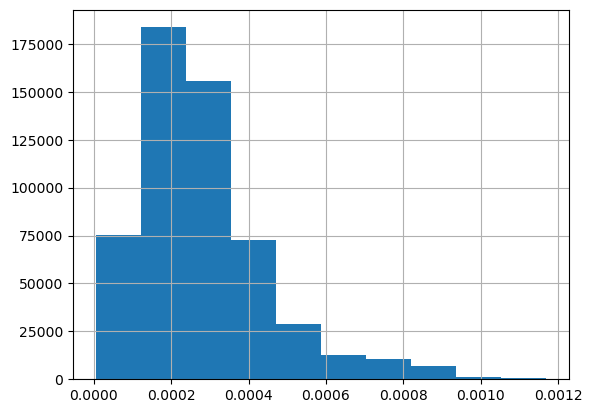

In [50]:
all_data.Infiltration.hist()

<Axes: >

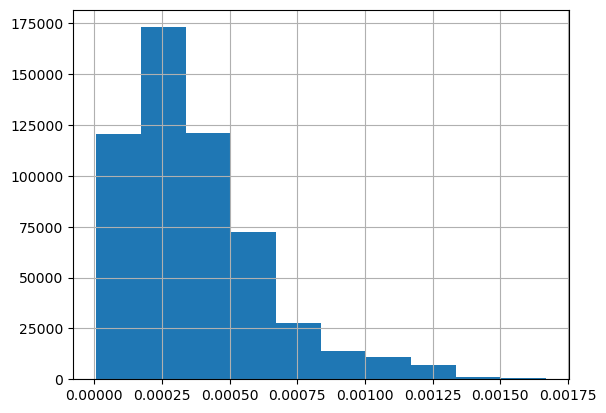

In [12]:
all_data.Infiltration.hist()